In [1]:
import numpy as np
import matplotlib.pyplot as plt
from synthetic import TestSuite
import torch

In [2]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [3]:
def min_max_transform(series):
  series_temp = np.copy(series)
  for i in range(len(series_temp)):
    series_temp[i] = (series_temp[i] - np.max(series))/(np.max(series)-np.min(series)) + 1
  return series_temp

In [4]:
import os, shutil
DIR="experiment_nn_cnn/"
FILE_NAME=DIR+"/log.csv"
if os.path.exists(DIR): shutil.rmtree(DIR)
if not os.path.exists(DIR): os.mkdir(DIR)

In [5]:
def outputExperiment(id, series_name, mixed, feature_length, target_length, target_offset, rmse_train, rmse_test, epochs):
    with open(FILE_NAME, 'a') as f:
        result = ", ".join(map(str, list([id, series_name , mixed , feature_length , target_length , target_offset , rmse_train , rmse_test, epochs])))
        print(result, file=f)

In [6]:
def showExperiment(ID, mixed, series, series_name, Y_train, Y_test, Yhat_train, Yhat_test, Yhat_series, rmse_train, rmse_test):
    plt.figure(figsize=(30,10))
    plt.subplot(411)
    plt.margins(0.05)
    plt.plot(series)
    plt.plot(Yhat_series)
    plt.legend(["True", "Predicted"])
    plt.title("Series: "+ series_name+" (Random Sampling="+str(mixed)+")")

    plt.subplot(412)
    plt.margins(0.05)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.legend(["RMSE Train", "RMSE Test"])
    plt.title("RMSE Train: "+ str(rmse_train[-1])+"\nRMSE Test: "+ str(rmse_test[-1]))

    plt.subplot(425)
    plt.margins(0.05)
    plt.plot(Y_train)
    plt.plot(Yhat_train)
    plt.legend(["True", "Predicted"])
    plt.title("Train")

    plt.subplot(426)
    plt.margins(0.05)
    plt.plot(Y_test)
    plt.plot(Yhat_test)
    plt.legend(["True", "Predicted"])
    plt.title("Test")

    plt.subplot(427)
    plt.margins(0.05)
    plt.plot(abs(Y_train - Yhat_train))
    plt.legend(["Residuals"])
    plt.title("Train")

    plt.subplot(428)
    plt.margins(0.05)
    plt.plot(abs(Y_test - Yhat_test))
    plt.legend(["Residuals"])
    plt.title("Test")

    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.savefig(DIR+str(ID)+".png", transparent=True)

# Convolutional Semilinear Neural Network

In [7]:
from src.models.nn import Model_ConvolutionalSemilinearNN

In [8]:
def executeNN(X_train, X_test, Y_train, Y_test):
    model_nn_cnn = Model_ConvolutionalSemilinearNN(error_fun=RMSE_Loss)
    model_nn_cnn.__train__(X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

    rmse_train = model_nn_cnn.__get_error_train__()
    rmse_test = model_nn_cnn.__get_error_test__()

    yhat_train = model_nn_cnn.__get_yhat_train__()
    yhat_test = model_nn_cnn.__get_yhat_test__()

    X_series, Y_series = np.concatenate((X_train, X_test), axis=0), np.concatenate((Y_train, Y_test), axis=0)
    X_series, Y_series = torch.tensor(X_series, dtype=torch.float32), torch.tensor(Y_series, dtype=torch.float32)
    model_nn_cnn.__test__(X_test=X_series, Y_test=Y_series)
    yhat_series = model_nn_cnn.__get_yhat_test__()
    
    return rmse_train, rmse_test, yhat_train, yhat_test, yhat_series, model_nn_cnn.epochs

In [9]:
def PipelineNN():
    synthetic_dataset_test_suite = TestSuite()

    synthetic_datasets =  synthetic_dataset_test_suite.__get_test_suite_size__()
    
    mixed = [True, False]
    feature_length = [1, 2, 3, 4, 5]
    target_offset = [1, 2, 3, 4, 5]
    target_length = [1]

    ID = 0
    print("\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format("ID", "Series", "Mixed", "Autoregressive Variables", "Target Length", "Target Offset", "RMSE Train", "RMSE Test", "EPOCHS"))
    for index in range(synthetic_datasets):
        series = synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(index)
        for ind_mixed in mixed:
            for ind_feature in feature_length:
                for ind_offset in target_offset:
                    for ind_target in target_length:
                        X_train, X_test, Y_train, Y_test = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
                            transform=min_max_transform,
                            series=series,
                            mixed=ind_mixed,
                            feature_length=ind_feature,
                            offset=ind_offset,
                            target_length=ind_target,
                            tensor = True
                        )
                        rmse_train, rmse_test, yhat_train, yhat_test, yhat_series, epochs = executeNN(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)
                        outputExperiment(
                            ID,
                            synthetic_dataset_test_suite.__get_name_test_series_from_index__(index),
                            ind_mixed,
                            ind_feature,
                            ind_offset,
                            ind_target,
                            rmse_train[-1],
                            rmse_test[-1],
                            epochs
                        )
                        showExperiment(
                            ID,
                            ind_mixed,
                            np.concatenate((Y_train, Y_test), axis=0),
                            synthetic_dataset_test_suite.__get_name_test_series_from_index__(index),
                            Y_train.detach().numpy(),
                            Y_test.detach().numpy(),
                            yhat_train.detach().numpy(),
                            yhat_test.detach().numpy(),
                            yhat_series.detach().numpy(),
                            rmse_train,
                            rmse_test
                        )
                        ID += 1
    

In [10]:
# PipelineNN()

In [11]:
from cross_validation.nn.cnn import KFoldCrossValidation_ConvolutionalSemilinearNN

In [ ]:
synthetic_dataset_test_suite = TestSuite()
cv_cnn = KFoldCrossValidation_ConvolutionalSemilinearNN(
    series = synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(6),
    loss = RMSE_Loss,
    one_step_offset_target= 5
)
cross_validation_param = {
    "features_length": [10],
    "semilinear_layers": [2, 6],
    "neurons_decision_making": [256],
    "dropout": [0.5],
    "options": {
        "tensor": True
    }
}
params, model = cv_cnn.search(cross_validation_param)

In [13]:
params

{'features_length': 10,
 'semilinear_layers': 2,
 'neurons_decision_making': 256,
 'dropout': 0.5}

In [14]:
model

In [15]:
_, X_test, _, Y_test = synthetic_dataset_test_suite.__train_and_test_from_numpy_series__(
    transform=min_max_transform,
    series=synthetic_dataset_test_suite.__get_numpy_test_series_from_index__(6),
    mixed=False,
    feature_length=params["features_length"],
    offset=5,
    target_length=1
)

In [16]:
model.__test__(torch.tensor(X_test, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32))
yhat = model.__get_yhat_test__()

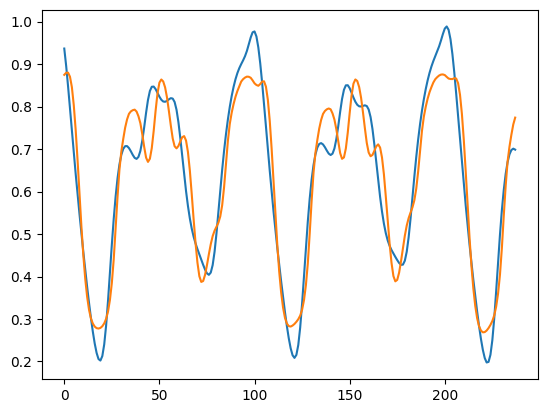

In [17]:
plt.plot(Y_test)
plt.plot(yhat)